# Heart Disease Prediction

## Guidelines

1. Introduction: You will briefly describe your data set and the problem you are trying
to solve.
2. Perform some unsupervised analysis: Look to see if any interesting structure
is present in the data. If you don’t find any interesting structure, describe what you
tried.
3. Supervised analysis: You must train at least three of the learning models discussed
in the class (e.g., Logistic regression, SVM, Neural Networks).1 For each model, you
must try different feature transformations and different regularization techniques.
2
For example, try the linear, polynomial, and radial-basis function kernel if you use
support vector machines in your project. Remember to illustrate (through graphs)
how your feature weights and error changed when you used different parameters,
regularizations, and normalizations.
4. Table of Results: You must create a table that contains the final results for your
model. It would be useful to have a table that includes the training accuracy and the
validation accuracy for every model you created. For example, suppose you’re using
Ridge Regression and manipulating the value of λ. In that case, your table should
contain the training and validation accuracy for every lambda value you used. You
should provide the precision and recall
5. Why: Your write-up should analytically discuss your experimental findings; and
what conclusions you can draw from your work. You should appeal to the concepts
discussed in class: overfitting, underfitting, variance, bias, etc.


## Import packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn import compose

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Introduction

We will be using the ["Heart Failure Prediction Dataset" from Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). It provides a set of 11 features that might attribute to whether there is a heart disease or not. 

The dataset provider supplies some information for the available attributes on Kaggle:

| Feature | Description | Values |
|-|-|-|
| Age | age of the patient | [years] |
| Sex | sex of the patient | [M: Male, F: Female] |
| ChestPainType | chest pain type | [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] |
| RestingBP | resting blood pressure | [mm Hg] |
| Cholesterol | serum cholesterol | [mm/dl] |
| FastingBS | fasting blood sugar | [1: if FastingBS > 120 mg/dl, 0: otherwise] |
| RestingECG | resting electrocardiogram results | [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] |
| MaxHR | maximum heart rate achieved | [Numeric value between 60 and 202] |
| ExerciseAngina | exercise-induced angina | [Y: Yes, N: No] |
| Oldpeak | oldpeak = ST | [Numeric value measured in depression] |
| ST_Slope | the slope of the peak exercise ST segment | [Up: upsloping, Flat: flat, Down: downsloping] |
| HeartDisease | output class | [1: heart disease, 0: Normal] |

The dataset is a `.csv` file containing 918 rows and 12 columns. 4 of them are discrete, and the rest are categorical. All of the 11 features (the first 11 columns) are risk factors that are potentially related to cardiovascular diseases. In this project, the target variable is `HeartDisease`, which represents if an individual has heart disease or not.

## Data Preprocessing

### Loading the data

In [2]:
data_df = pd.read_csv('heart.csv')
data_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### Encoding Features

In [3]:
sex_oh_enc = pd.get_dummies(data_df["Sex"], dtype="int").rename(columns={"F":"Female", "M":"Male"})
chestPain_oh_enc = pd.get_dummies(data_df["ChestPainType"], dtype="int").rename(columns={"TA":"ChestPain_TA", "ATA":"ChestPain_ATA", "NAP":"ChestPain_NAP","ASY":"ChestPain_ASY"})
restECG_oh_enc = pd.get_dummies(data_df["RestingECG"], dtype="int").rename(columns={"Normal":"RestECG_Normal", "ST":"RestECG_ST", "LVH":"RestECG_LVH"})
st_slope_oh_enc = pd.get_dummies(data_df["ST_Slope"], dtype="int").rename(columns={"Up":"ST_Slope_Up", "Flat":"ST_Slope_Flat", "Down":"ST_Slope_Down"})
exerciseAngina_ord_enc = pd.DataFrame(pd.factorize(data_df["ExerciseAngina"])[0], columns=["ExerciseAngina"])

data_df_encoded = data_df.drop(columns=["Sex", "ChestPainType", "RestingECG", "ST_Slope", "ExerciseAngina"])
data_df_encoded = data_df_encoded.join([sex_oh_enc, chestPain_oh_enc, restECG_oh_enc, st_slope_oh_enc, exerciseAngina_ord_enc])
data_df_encoded = data_df_encoded[["Age",
                                  "Male", "Female",
                                  "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY",
                                  "RestingBP",
                                  "Cholesterol",
                                  "FastingBS",
                                  "RestECG_Normal", "RestECG_ST", "RestECG_LVH",
                                  "MaxHR",
                                  "ExerciseAngina",
                                  "Oldpeak",
                                  "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down",
                                  "HeartDisease"]]
categorical_columns = ["Male", "Female", "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY", "FastingBS", "RestECG_Normal", "RestECG_ST", "RestECG_LVH", "ExerciseAngina", "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down", "HeartDisease"]
for col in categorical_columns:
    data_df_encoded[col] = data_df_encoded[col].astype("category")
feature_names = data_df_encoded.columns
data_df_encoded

,Age,Male,Female,ChestPain_TA,ChestPain_ATA,ChestPain_NAP,ChestPain_ASY,RestingBP,Cholesterol,FastingBS,RestECG_Normal,RestECG_ST,RestECG_LVH,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
0,40,1,0,0,1,0,0,140,289,0,1,0,0,172,0,0.0,1,0,0,0
1,49,0,1,0,0,1,0,160,180,0,1,0,0,156,0,1.0,0,1,0,1
2,37,1,0,0,1,0,0,130,283,0,0,1,0,98,0,0.0,1,0,0,0
3,48,0,1,0,0,0,1,138,214,0,1,0,0,108,1,1.5,0,1,0,1
4,54,1,0,0,0,1,0,150,195,0,1,0,0,122,0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,0,1,0,0,0,110,264,0,1,0,0,132,0,1.2,0,1,0,1
914,68,1,0,0,0,0,1,144,193,1,1,0,0,141,0,3.4,0,1,0,1
915,57,1,0,0,0,0,1,130,131,0,1,0,0,115,1,1.2,0,1,0,1
916,57,0,1,0,1,0,0,130,236,0,0,0,1,174,0,0.0,0,1,0,1


### Separating features from target

In [4]:
X = np.array(data_df_encoded)[:,:-1]
y = np.array(data_df_encoded)[:,-1]

# Data Analysis with Visualizations

## Discrete Data

### Plotting

By observing the columns present in the dataset in its raw format, we can see that there are 4 discrete features: `Age`, `RestingBP`, `Cholesterol`, and `MaxHR`. It would be helpful if we can find a way to plot these data and check their relationships with `HeartDisease` being positive.

Scatter plots would be appropriate for discrete features. Assuming that we will be doing a 2D scatter plot, we need to first determine the x and y axis.

Because `HeartDisease` is categorical, we cannot use it as one of the axis. Instead, we can denote it using different colors, and use `Age` as the x-axis, all the other features in a subplot as the y-axis.

In [5]:
print(data_df_encoded.select_dtypes(include="int"))

     Age  RestingBP  Cholesterol  MaxHR
0     40        140          289    172
1     49        160          180    156
2     37        130          283     98
3     48        138          214    108
4     54        150          195    122
..   ...        ...          ...    ...
913   45        110          264    132
914   68        144          193    141
915   57        130          131    115
916   57        130          236    174
917   38        138          175    173

[918 rows x 4 columns]


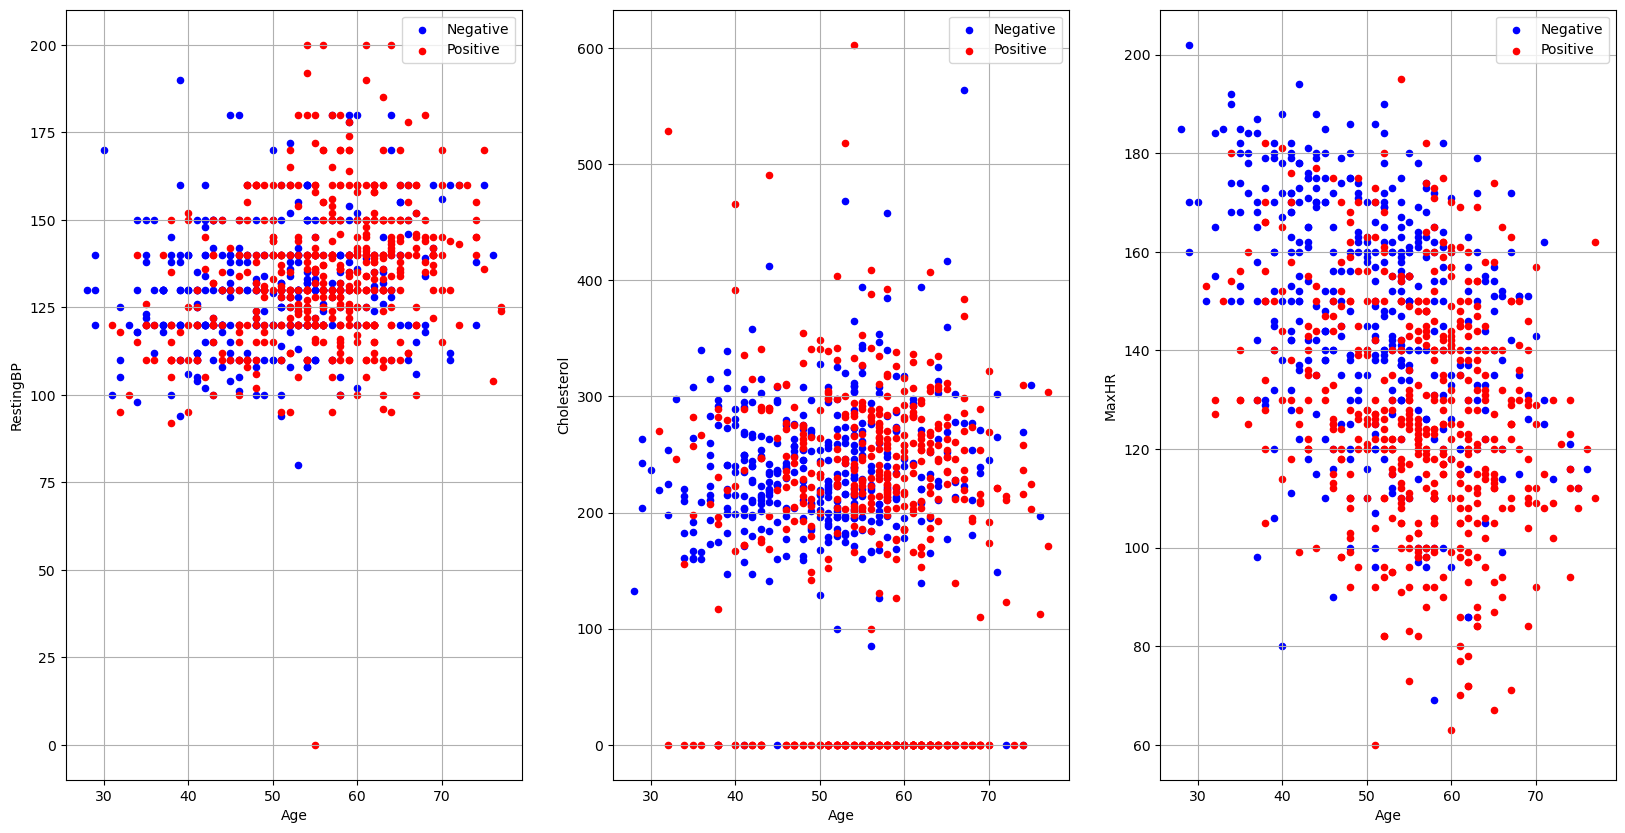

In [6]:
# Three plots for three features
fig, axs = plt.subplots(1, 3, figsize=(20,10))

# Only include the discrete features
data_df_discrete = data_df_encoded.select_dtypes(include="int")
data_discrete = np.array(data_df_discrete)

# Create the scatter plots for each feature plotting all the data points
for (idx, ax), X_tmp, label in zip(enumerate(axs.ravel()), data_discrete.T[1:], list(data_df_discrete)[1:]):
   ax.scatter(data_discrete.T[0][y[:]==0], X_tmp[y[:]==0], s=20, color="blue", label="Negative")
   ax.scatter(data_discrete.T[0][y[:]==1], X_tmp[y[:]==1], s=20, color="red", label="Positive")
   ax.grid()
   ax.legend()
   ax.set_xlabel("Age")
   ax.set_ylabel(label)

plt.show()

### Analysis

Just by looking at the plots, we can see some pattern in the relationships between the age and the other discrete features.

`RestingBP` appears to be only slightly higher for older people, but we do see more data points with `HeartDisease` being positive with slightly higher `RestingBP` in general.

`Cholesterol` seems to have plenty of outliers that have a value of 0, and most of these outliers do have `HeartDisease`. Otherwise, there is not a clear trend of increase or decrease of `Cholesterol`, or relationship between `HeartDisease` being positive.

`MaxHR` is inversely proportional to `Age`, and it is pretty obvious that with lower `MaxHR`, there are more points with positive `HeartDisease`.

## Categorical Data

### Plotting

Similarly, we want to visualize the categorical data separately. Based on the encoded data using one-hot, we can create a bar chart for each encoded feature. This includes `Male`, `Female`, `ChestPain_TA`, `ChestPain_ATA`, `ChestPain_NAP`, `ChestPain_ASY`, `FastingBS`, `RestECG_Normal`, `RestECG_ST`, `RestECG_LVH`, `ExerciseAngina`, `ST_Slope_Up`, `ST_Slope_Flat`, and `ST_Slope_Down`.

Note that the prefixes indicate where each one-hot encoded value used to belong to which categorical feature in the raw data. This will be helpful when we analyze the bar chart later.

To see how each of these features are related to `HeartDisease`, we could make the y-axis the frequency of the one-hot encoded value being 1. But that would make it harder to compare between features, because each one-hot encoded value might have its own distribution already. For example, we could not compare the number of `HeartDisease` positives for `Male` and `ST_Slope_Flat` when there are 300 males and 50 `ST_Slope_Flat` with 1's in total. Instead, we calculate the percentage of positive `HeartDisease` rows for each feature.

In [7]:
", ".join(map(lambda s: f"`{s}`", data_df_encoded.select_dtypes(include="category")))

'`Male`, `Female`, `ChestPain_TA`, `ChestPain_ATA`, `ChestPain_NAP`, `ChestPain_ASY`, `FastingBS`, `RestECG_Normal`, `RestECG_ST`, `RestECG_LVH`, `ExerciseAngina`, `ST_Slope_Up`, `ST_Slope_Flat`, `ST_Slope_Down`, `HeartDisease`'

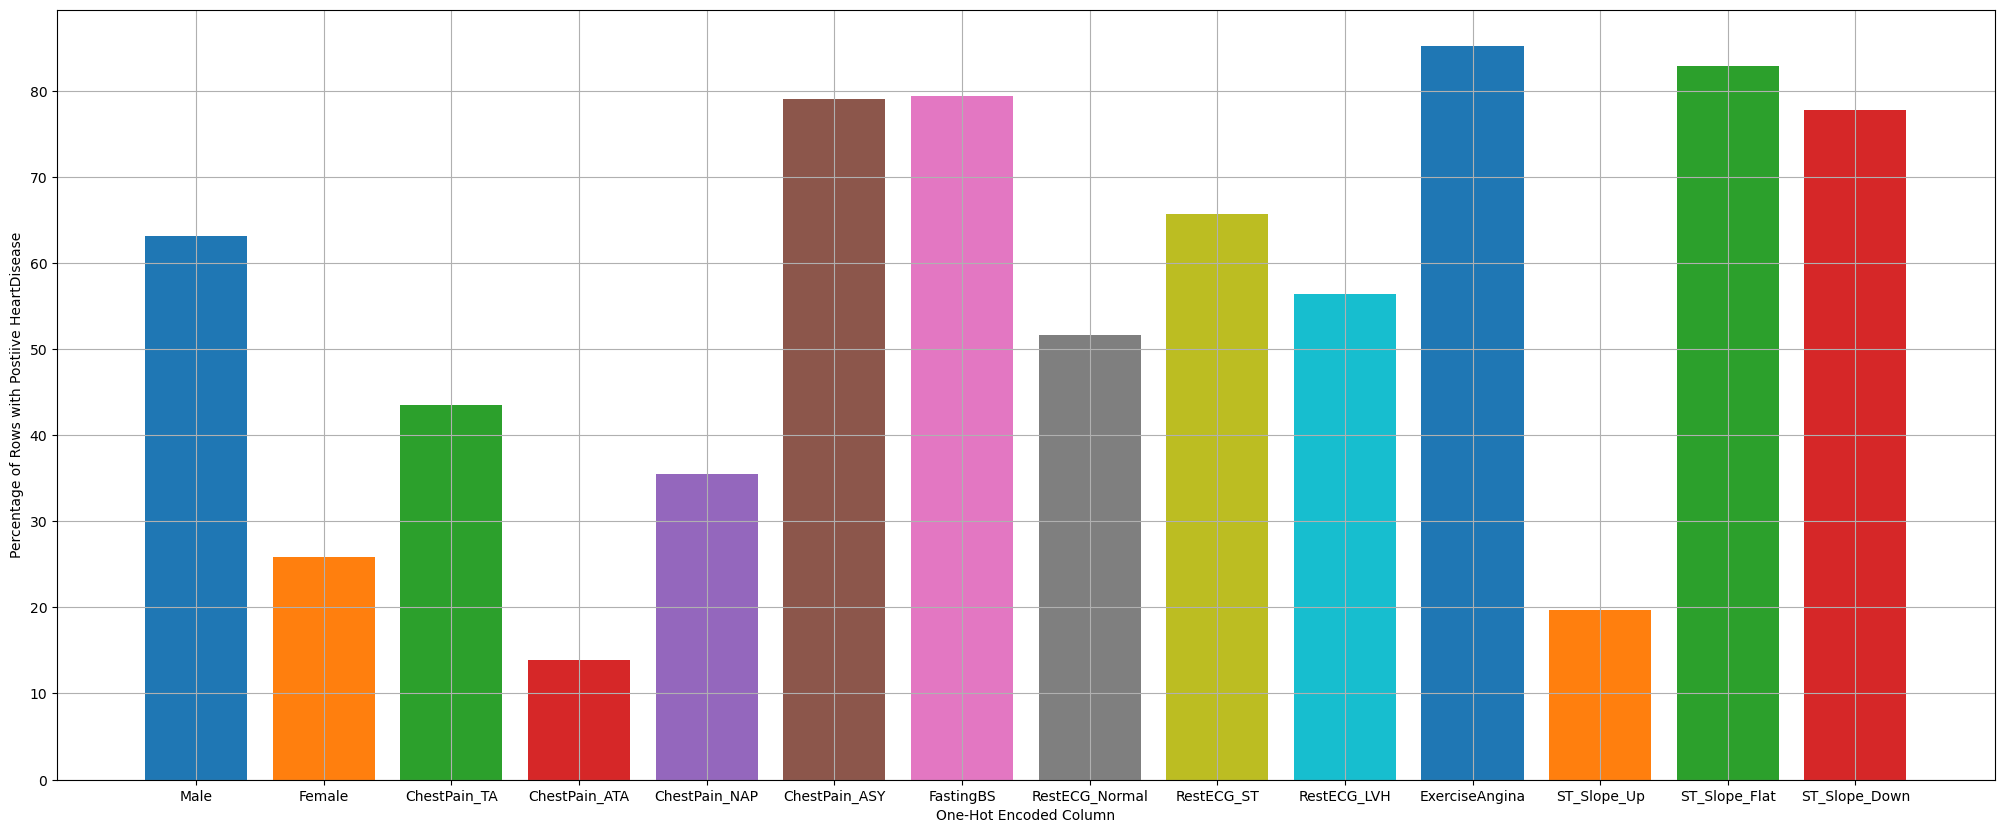

In [8]:
data_df_categorical = data_df_encoded.select_dtypes(include="category")

fig, ax = plt.subplots(figsize=(25,10))

for column in data_df_categorical:
   if column == "HeartDisease":
      continue
   # Count the number of rows with feature being 1 and HeartDisease being 1
   total_count = data_df_categorical[data_df_categorical[column]==1]['HeartDisease'].count()
   positive_count = data_df_categorical[data_df_categorical[column]==1]['HeartDisease'].astype("int").sum()
    
   # Plot the bar chart
   ax.bar(column, positive_count/total_count * 100)

# Set the x-axis and y-axis labels and show the chart
ax.set_xlabel('One-Hot Encoded Column')
ax.set_ylabel("Percentage of Rows with Postiive HeartDisease")
ax.grid()
plt.show()

### Analysis

There are `60%` of male out of all males that are diagnosed with heart disease, while there are only around `25%` of females that do have heart disease.

Regarding chest pain, `ChestPain_ASY` have the most positive diagnosis of heart disease, in the decreasing order follows `ChestPain_TA`, `ChestPain_NAP` and `ChestPain_ATA`.

There also seem to be a strong correlation between `FastingBS` and heart disease, where `80%` of the data points with `FastingBS` have a heart disease.

For the features staring with `RestECG` (resting electrocardiogram results), `65%` of `PestECG_ST` have positive `HeartDisease`. Overall, these features have similar percentages.

Most of the people (`80%`) who have `ExerciseAngina` (exercise-induced angina) are diagnosed with heart disease.

As for `ST_Slope` (the slope of the peak exercise ST segment), only `20%` of those who have an upward slope gets heart disease, but flat and downward slopes seem to indicate pretty high percentage of positive heart disease diagnosis.

### Splitting data into train and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=8)

### Feature Scaling/Normalization

In [10]:
# Normalize age, RestingBP, Cholesterol, MaxHR, and oldPeak

# Standardization (Z-score normzalization): zero-centered & unit variance
ct_std = compose.ColumnTransformer([("standard_scaler", preprocessing.StandardScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

# Min/Max Normalization (Linear Scaling): [0,1]
ct_mm = compose.ColumnTransformer([("min_max_scaler", preprocessing.MinMaxScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

X_train_std = ct_std.fit_transform(X_train)
X_test_std = ct_mm.fit_transform(X_test)
X_train_mm = ct_std.fit_transform(X_train)
X_test_mm = ct_mm.fit_transform(X_test)

### Add column of ones to data

In [11]:
def add_ones(X_in):
    X_out = np.hstack((np.ones((X_in.shape[0],1)), X_in))
    return X_out

X_train_us_1 =  add_ones(X_train)
X_test_us_1 = add_ones(X_test)

X_train_std_1 = add_ones(X_train_std)
X_test_std_1 = add_ones(X_test_std)

X_train_mm_1 = add_ones(X_train_mm)
X_test_mm_1 = add_ones(X_test_mm)

## Logistic Regression

### Feature Transformations

In [12]:
X_train_us_polys = {}
X_test_us_polys = {}

X_train_std_polys = {}
X_test_std_polys = {}

X_train_mm_polys = {}
X_test_mm_polys = {}

model_degrees = range(1,3)

for degree in model_degrees:
    poly = preprocessing.PolynomialFeatures(degree)
    
    X_train_us_polys[degree] = poly.fit_transform(X_train_us_1)
    X_test_us_polys[degree] = poly.fit_transform(X_test_us_1)
    
    X_train_std_polys[degree] = poly.fit_transform(X_train_std_1)
    X_test_std_polys[degree] = poly.fit_transform(X_test_std_1)

    X_train_mm_polys[degree] = poly.fit_transform(X_train_mm_1)
    X_test_mm_polys[degree] = poly.fit_transform(X_test_mm_1)

### Regularization with Different Parameters

unscaled, degree 1
	Training:
               precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       321
         1.0       0.87      0.90      0.88       413

    accuracy                           0.87       734
   macro avg       0.87      0.86      0.86       734
weighted avg       0.87      0.87      0.86       734

	Test:
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.84        89
         1.0       0.84      0.85      0.85        95

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

standardized, degree 1
	Training:
               precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       321
         1.0       0.87      0.92      0.89       413

    accuracy                           0.88       734
   macro avg       0.88      0.87      0.87       734


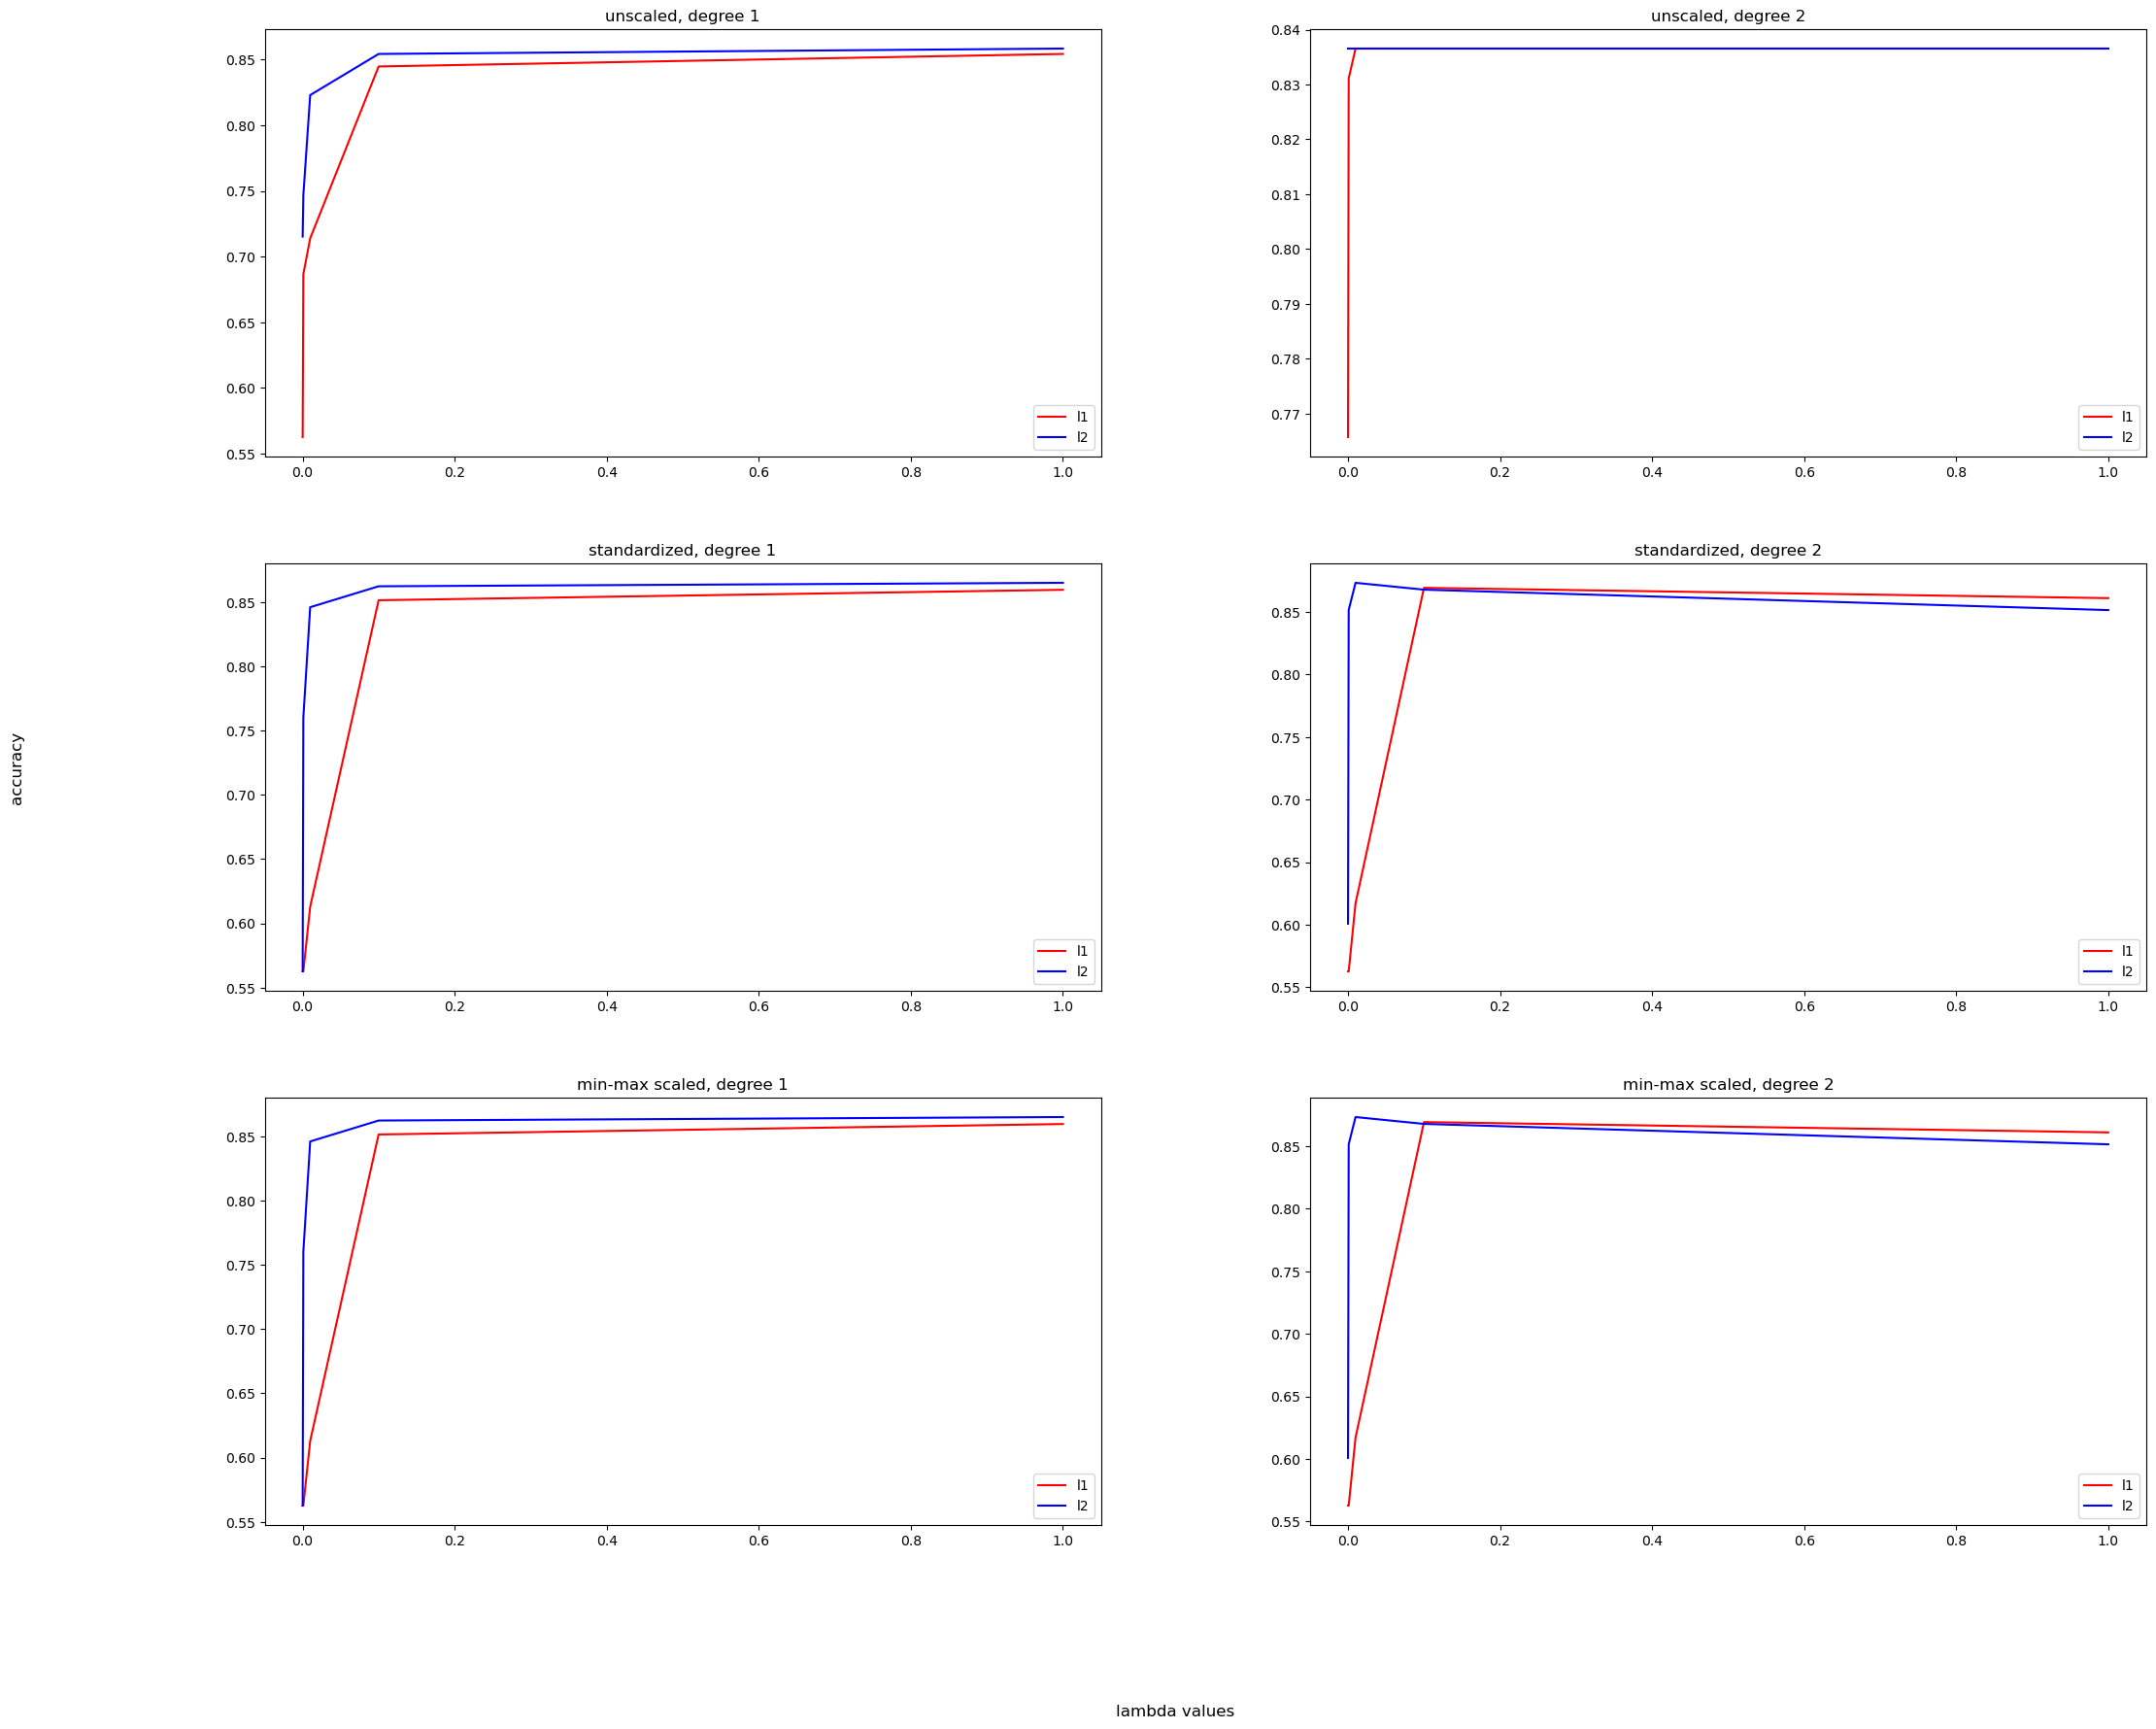

In [39]:
pipe = Pipeline(steps=[('logistic', LogisticRegression(max_iter=10000, solver="saga"))])
param_grid = {
    "logistic__penalty": ["l1", "l2"],
    "logistic__C": [0.0001, 0.001, 0.01, 0.1, 1]
}
search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=4)

fig, axs = plt.subplots(3, 2, gridspec_kw=dict(wspace=.25, hspace=.25), figsize=(25, 20))
fig.supxlabel("lambda values")
fig.supylabel("accuracy")

def plot_lambda_results(axs, cv_results, title):
    res = pd.DataFrame(cv_results)
    l1_vals = {}
    l2_vals = {}
    for ind, val in enumerate(res["param_logistic__penalty"]):
        if (val == "l1"):
            l1_vals[res["param_logistic__C"][ind]] = (res["mean_test_score"][ind])
        else:
            l2_vals[res["param_logistic__C"][ind]] = (res["mean_test_score"][ind])
    axs.plot(l1_vals.keys(), l1_vals.values(), color="red", label="l1")
    axs.plot(l2_vals.keys(), l2_vals.values(), color="blue", label="l2")
    axs.set_title(title)
    axs.legend(loc="lower right")


for degree in model_degrees:
    search.fit(X_train_us_polys[degree], y_train)
    plot_lambda_results(axs[0][degree-1], search.cv_results_, "unscaled, degree " + str(degree))
    print("unscaled, degree " + str(degree))
    print("\tTraining:\n", classification_report(y_train, search.best_estimator_.predict(X_train_us_polys[degree])))
    print("\tTest:\n", classification_report(y_test, search.best_estimator_.predict(X_test_us_polys[degree])))

    search.fit(X_train_std_polys[degree], y_train)
    plot_lambda_results(axs[1][degree-1], search.cv_results_, "standardized, degree " + str(degree))
    print("standardized, degree " + str(degree))
    print("\tTraining:\n", classification_report(y_train, search.best_estimator_.predict(X_train_std_polys[degree])))
    print("\tTest:\n", classification_report(y_test, search.best_estimator_.predict(X_test_std_polys[degree])))

    search.fit(X_train_mm_polys[degree], y_train)
    plot_lambda_results(axs[2][degree-1], search.cv_results_, "min-max scaled, degree " + str(degree))
    print("min-max scaled, degree " + str(degree))
    print("\tTraining:\n", classification_report(y_train, search.best_estimator_.predict(X_train_mm_polys[degree])))
    print("\tTest:\n", classification_report(y_test, search.best_estimator_.predict(X_test_mm_polys[degree])))

In [34]:
logreg = LogisticRegression(penalty=None, max_iter=10000, solver="saga")

for degree in model_degrees:
    logreg.fit(X_train_us_polys[degree], y_train)
    print("unscaled, degree "+str(degree)+":", logreg.score(X_test_us_polys[degree], y_test)*100)
    print("\tTraining:\n", classification_report(y_train, logreg.predict(X_train_us_polys[degree])))
    print("\tTest:\n", classification_report(y_test, logreg.predict(X_test_us_polys[degree])))

    logreg.fit(X_train_std_polys[degree], y_train)
    print("standardized, degree "+str(degree)+":", logreg.score(X_test_std_polys[degree], y_test)*100)
    print("\tTraining:\n", classification_report(y_train, logreg.predict(X_train_std_polys[degree])))
    print("\tTest:\n", classification_report(y_test, logreg.predict(X_test_std_polys[degree])))

    logreg.fit(X_train_mm_polys[degree], y_train)
    print("min-max scaled, degree "+str(degree)+":", logreg.score(X_test_mm_polys[degree], y_test)*100)
    print("\tTraining:\n", classification_report(y_train, logreg.predict(X_train_mm_polys[degree])))
    print("\tTest:\n", classification_report(y_test, logreg.predict(X_test_mm_polys[degree])))

unscaled, degree 1: 84.23913043478261
	Training:
               precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       321
         1.0       0.87      0.90      0.88       413

    accuracy                           0.87       734
   macro avg       0.87      0.86      0.86       734
weighted avg       0.87      0.87      0.86       734

	Test:
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.84        89
         1.0       0.84      0.85      0.85        95

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

standardized, degree 1: 83.69565217391305
	Training:
               precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       321
         1.0       0.87      0.91      0.89       413

    accuracy                           0.88       734
   macro avg    

Best performance from tests: ~85% accuracy from Logistic Regression with L2 regularization using $\lambda=0.01$ on standardized or min-max scaled data with a polynomial transformation of degree 2.